# MLP
MLP, K=5, epochs=200.
Use lncRNA.
Get ready to train on canonical, test on all.

Train set: filter none. Canonical.
Test set: filter none. Canonical

In [1]:
from datetime import datetime
print(datetime.now())

2023-04-04 18:40:19.009458


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-04 18:40:53.585760
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                65664     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if not FILTER_TEST or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if not FILTER_TRAIN or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-04 18:40:54.404619
Load training data
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.

Training # 1 1
2023-04-04 18:41:17.797465
2023-04-04 18:41:18.011596
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-04-04 18:41:18.101662


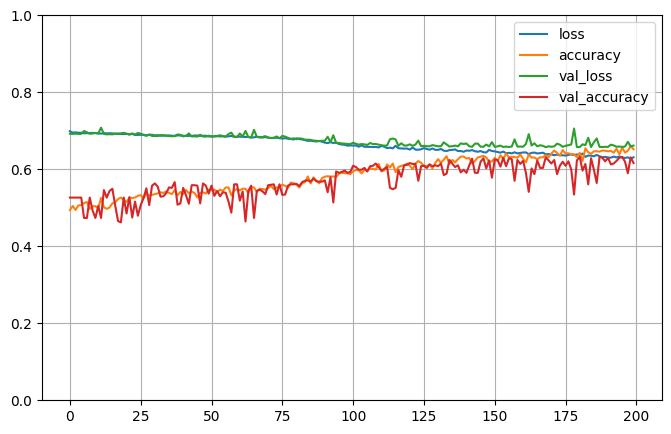


Testing # 1 1
2023-04-04 18:43:41.833574
2023-04-04 18:43:41.833609
2023-04-04 18:43:41.833653
PREDICT
2023-04-04 18:43:41.855117
Test 1:0 458:412 52.64%
Predict 1:0 628:242 72.18%
Test sizes (870, 1025) (870,)
Range of scores: 0.023257148 to 0.96032655
Score threshold 0.5
Confusion matrix
 [[160 252]
 [ 82 376]]
Normalized matrix
 [[0.18390805 0.28965517]
 [0.09425287 0.43218391]]


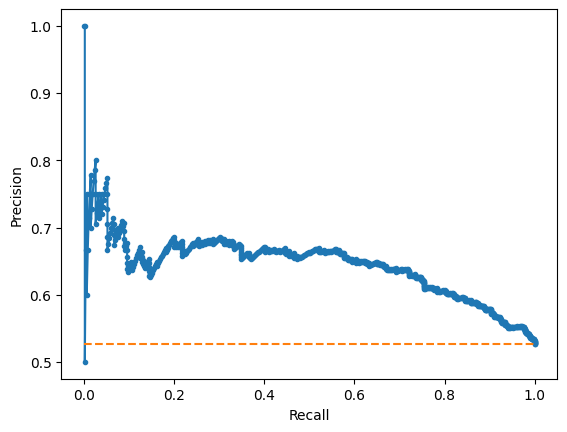

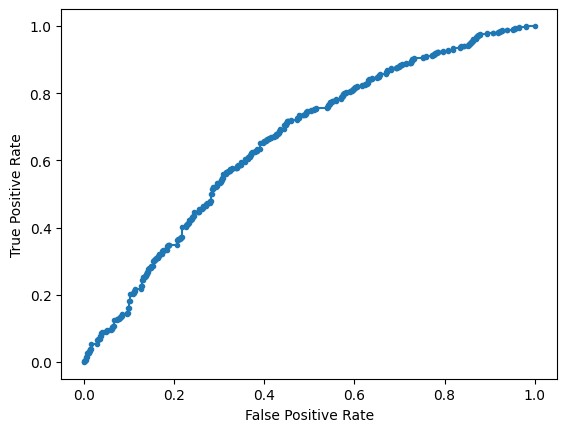

Accuracy: 61.61% Precision: 59.87% Recall: 82.10%
F1: 69.24% MCC: 0.2332
AUPRC: 64.46% AUROC: 65.76%
 accuracy [61.60919540229885]
 precision [59.87261146496815]
 recall [82.09606986899564]
 F1 [69.24493554327809]
 MCC [0.2332299194736913]
 AUPRC [64.45888760454139]
 AUROC [65.75762072327977]

Training # 1 2
2023-04-04 18:43:42.936446
2023-04-04 18:43:43.160365
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-04-04 18:43:43.306383


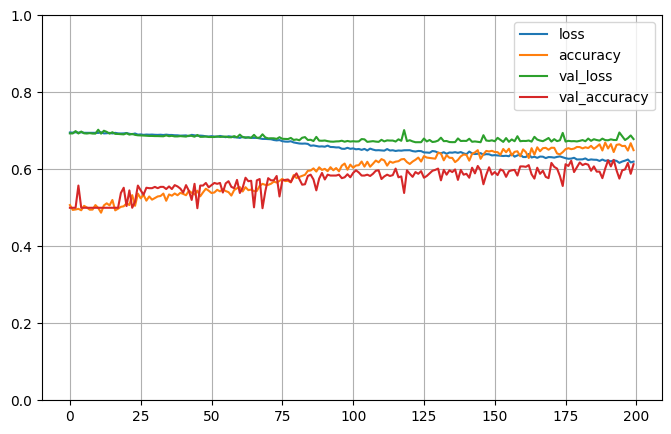


Testing # 1 2
2023-04-04 18:45:15.443820
2023-04-04 18:45:15.443861
2023-04-04 18:45:15.443909
PREDICT
2023-04-04 18:45:15.458191
Test 1:0 442:442 50.00%
Predict 1:0 582:302 65.84%
Test sizes (884, 1025) (884,)
Range of scores: 0.010692295 to 0.98169464
Score threshold 0.5
Confusion matrix
 [[201 241]
 [101 341]]
Normalized matrix
 [[0.22737557 0.27262443]
 [0.11425339 0.38574661]]


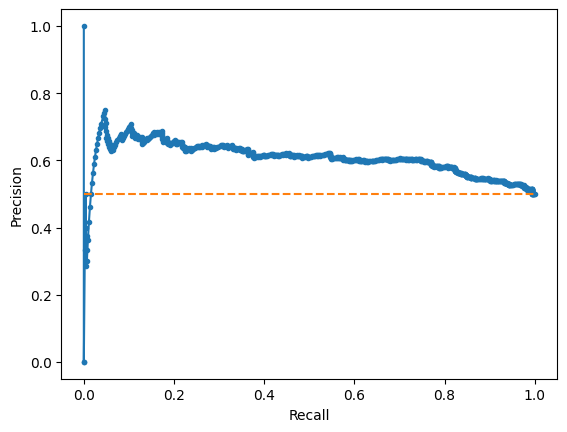

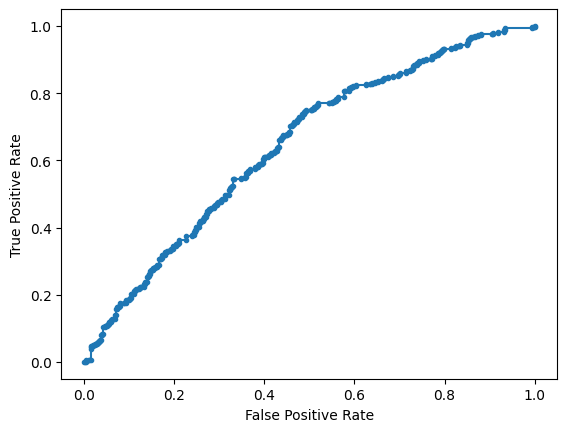

Accuracy: 61.31% Precision: 58.59% Recall: 77.15%
F1: 66.60% MCC: 0.2385
AUPRC: 60.58% AUROC: 64.45%
 accuracy [61.31221719457014]
 precision [58.591065292096225]
 recall [77.14932126696833]
 F1 [66.60156250000001]
 MCC [0.23852562154428517]
 AUPRC [60.582686939527875]
 AUROC [64.45455662250978]

Training # 1 3
2023-04-04 18:45:16.387460
2023-04-04 18:45:16.602693
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-04-04 18:45:16.697557


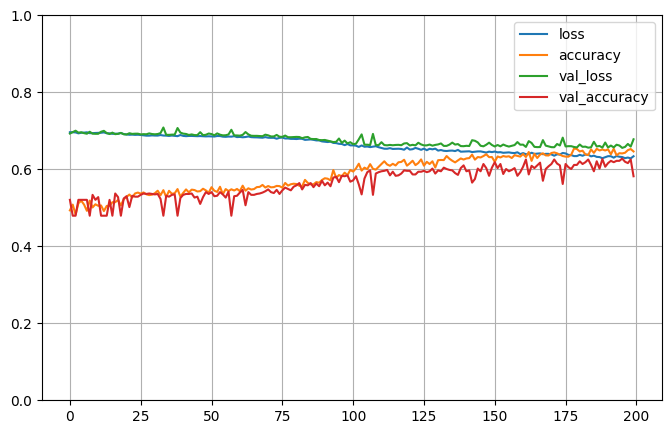


Testing # 1 3
2023-04-04 18:47:40.079517
2023-04-04 18:47:40.080045
2023-04-04 18:47:40.082047
PREDICT
2023-04-04 18:47:40.096271
Test 1:0 442:407 52.06%
Predict 1:0 209:640 24.62%
Test sizes (849, 1025) (849,)
Range of scores: 0.027600283 to 0.9330581
Score threshold 0.5
Confusion matrix
 [[346  61]
 [294 148]]
Normalized matrix
 [[0.40753828 0.07184923]
 [0.34628975 0.17432273]]


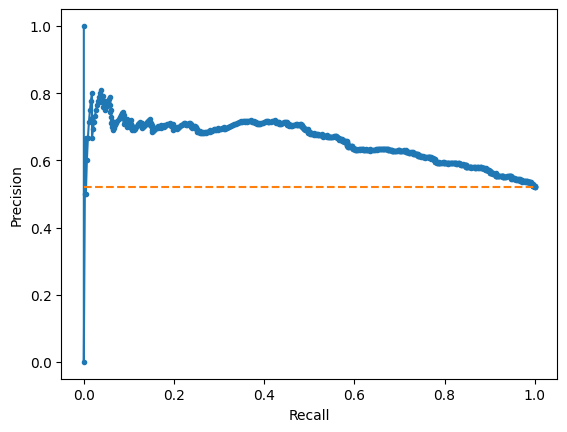

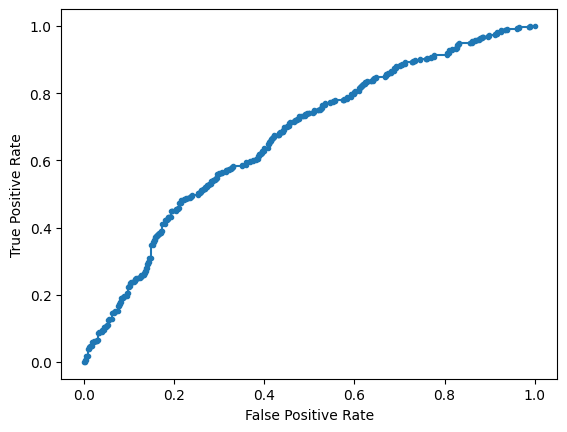

Accuracy: 58.19% Precision: 70.81% Recall: 33.48%
F1: 45.47% MCC: 0.2145
AUPRC: 65.71% AUROC: 66.82%
 accuracy [58.18610129564193]
 precision [70.81339712918661]
 recall [33.4841628959276]
 F1 [45.46850998463901]
 MCC [0.21450308515731323]
 AUPRC [65.71199552210436]
 AUROC [66.81934917229034]

Training # 1 4
2023-04-04 18:47:40.717362
2023-04-04 18:47:40.944965
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-04-04 18:47:41.037524


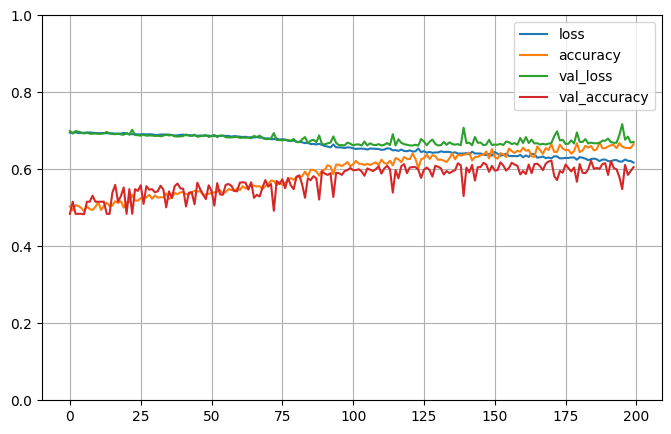


Testing # 1 4
2023-04-04 18:50:04.323854
2023-04-04 18:50:04.323890
2023-04-04 18:50:04.323962
PREDICT
2023-04-04 18:50:04.347013
Test 1:0 459:431 51.57%
Predict 1:0 470:420 52.81%
Test sizes (890, 1025) (890,)
Range of scores: 0.007586007 to 0.9536551
Score threshold 0.5
Confusion matrix
 [[250 181]
 [170 289]]
Normalized matrix
 [[0.28089888 0.20337079]
 [0.19101124 0.3247191 ]]


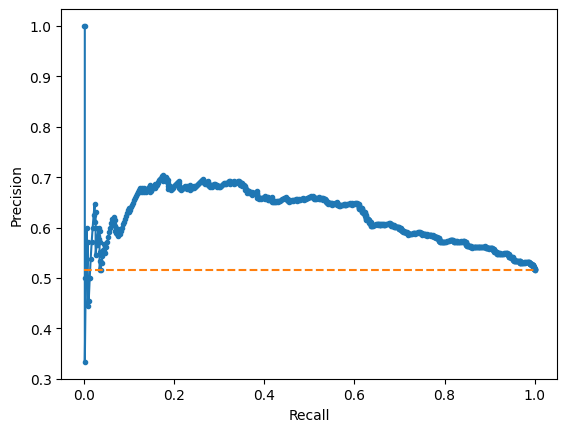

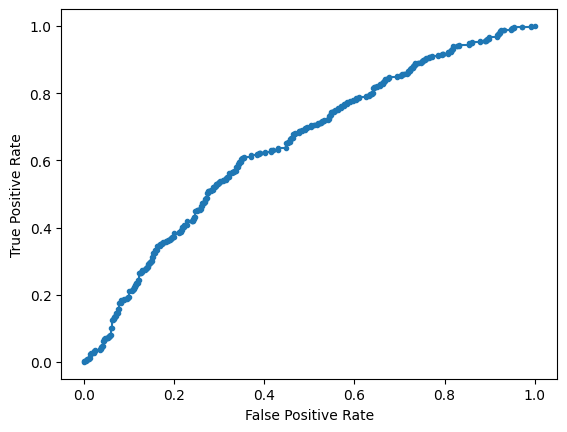

Accuracy: 60.56% Precision: 61.49% Recall: 62.96%
F1: 62.22% MCC: 0.2099
AUPRC: 62.38% AUROC: 64.62%
 accuracy [60.561797752808985]
 precision [61.48936170212767]
 recall [62.96296296296296]
 F1 [62.21743810548978]
 MCC [0.2099037491468225]
 AUPRC [62.37787344556553]
 AUROC [64.6224769877015]

Training # 1 5
2023-04-04 18:50:05.008158
2023-04-04 18:50:05.222390
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-04-04 18:50:05.341160


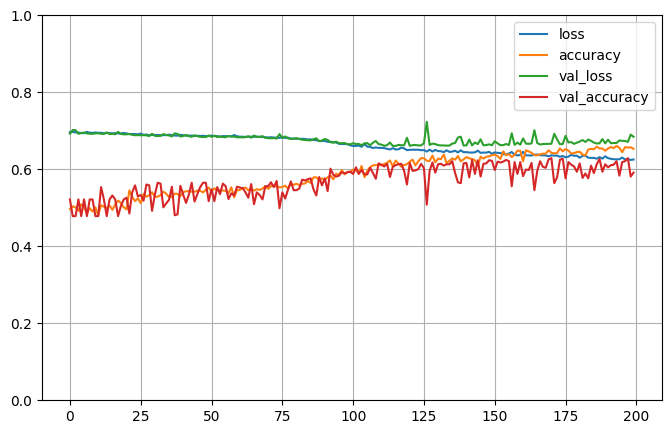


Testing # 1 5
2023-04-04 18:51:32.374324
2023-04-04 18:51:32.374365
2023-04-04 18:51:32.374433
PREDICT
2023-04-04 18:51:32.387800
Test 1:0 457:419 52.17%
Predict 1:0 287:589 32.76%
Test sizes (876, 1025) (876,)
Range of scores: 0.01110484 to 0.9667265
Score threshold 0.5
Confusion matrix
 [[325  94]
 [264 193]]
Normalized matrix
 [[0.37100457 0.10730594]
 [0.30136986 0.22031963]]


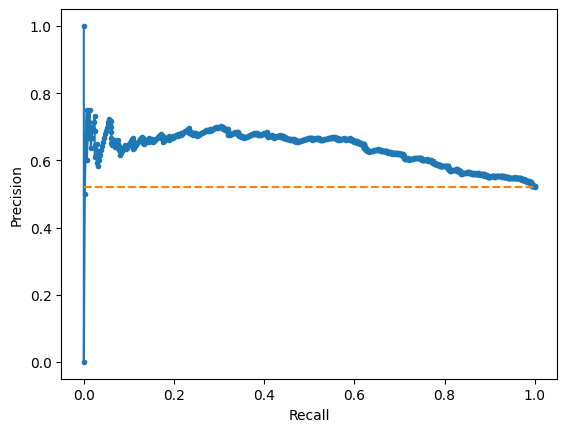

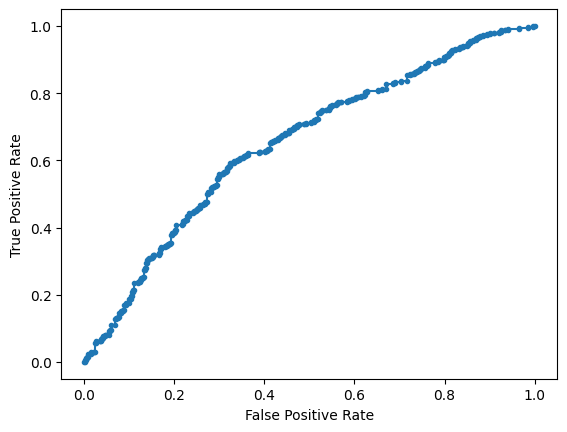

Accuracy: 59.13% Precision: 67.25% Recall: 42.23%
F1: 51.88% MCC: 0.2107
AUPRC: 63.47% AUROC: 64.93%
 accuracy [59.1324200913242]
 precision [67.24738675958189]
 recall [42.23194748358862]
 F1 [51.88172043010753]
 MCC [0.210706833734727]
 AUPRC [63.46935334267734]
 AUROC [64.92639033230103]

Training # 2 1
2023-04-04 18:51:33.019724
2023-04-04 18:51:33.222957
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-04-04 18:51:33.328438


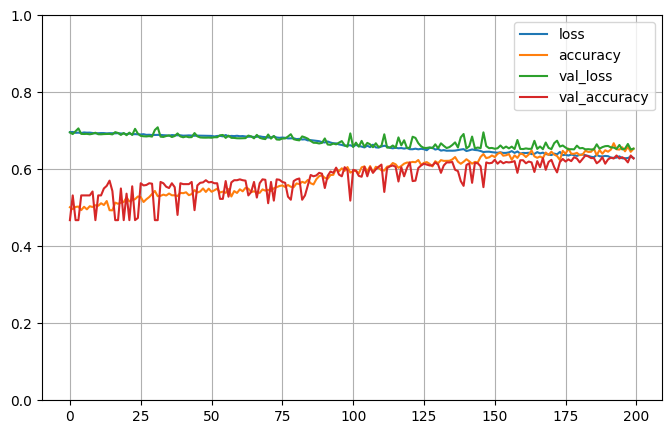


Testing # 2 1
2023-04-04 18:53:01.824257
2023-04-04 18:53:01.824295
2023-04-04 18:53:01.824341
PREDICT
2023-04-04 18:53:01.838297
Test 1:0 472:415 53.21%
Predict 1:0 478:409 53.89%
Test sizes (887, 1025) (887,)
Range of scores: 0.037122875 to 0.9876957
Score threshold 0.5
Confusion matrix
 [[247 168]
 [162 310]]
Normalized matrix
 [[0.27846674 0.18940248]
 [0.18263811 0.34949267]]


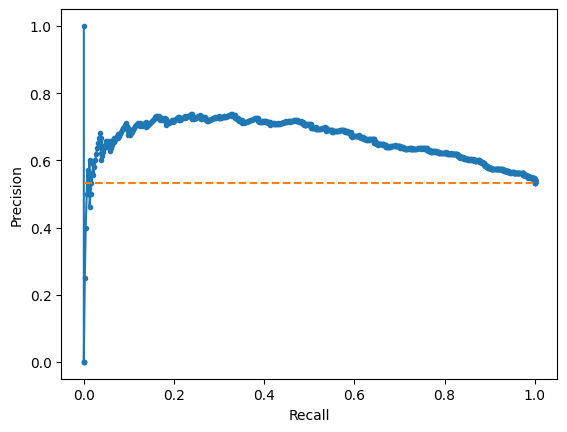

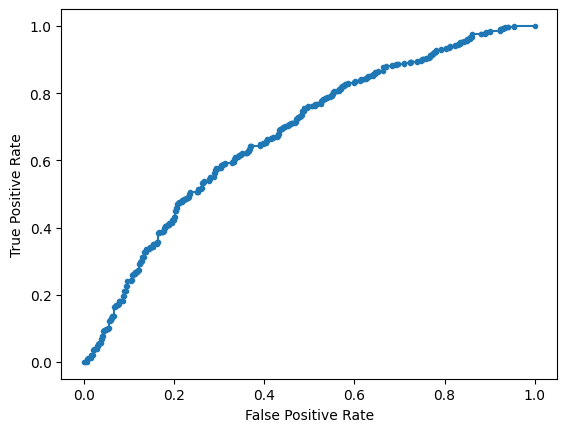

Accuracy: 62.80% Precision: 64.85% Recall: 65.68%
F1: 65.26% MCC: 0.2522
AUPRC: 66.34% AUROC: 67.93%
 accuracy [62.79594137542277]
 precision [64.85355648535564]
 recall [65.67796610169492]
 F1 [65.26315789473684]
 MCC [0.25220384697492515]
 AUPRC [66.34264655748635]
 AUROC [67.9318970798448]

Training # 2 2
2023-04-04 18:53:02.466060
2023-04-04 18:53:02.687015
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-04-04 18:53:02.795086


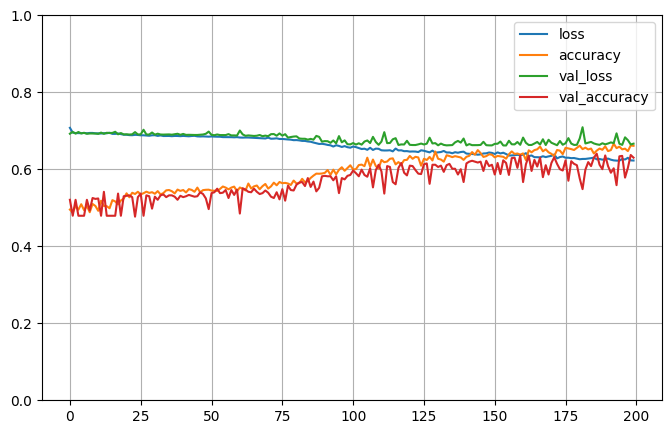


Testing # 2 2
2023-04-04 18:55:26.141864
2023-04-04 18:55:26.141904
2023-04-04 18:55:26.141963
PREDICT
2023-04-04 18:55:26.155336
Test 1:0 452:416 52.07%
Predict 1:0 405:463 46.66%
Test sizes (868, 1025) (868,)
Range of scores: 0.008707013 to 0.9398481
Score threshold 0.5
Confusion matrix
 [[279 137]
 [184 268]]
Normalized matrix
 [[0.32142857 0.1578341 ]
 [0.21198157 0.30875576]]


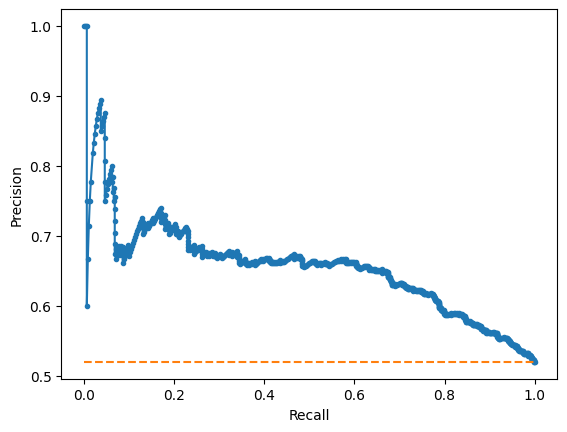

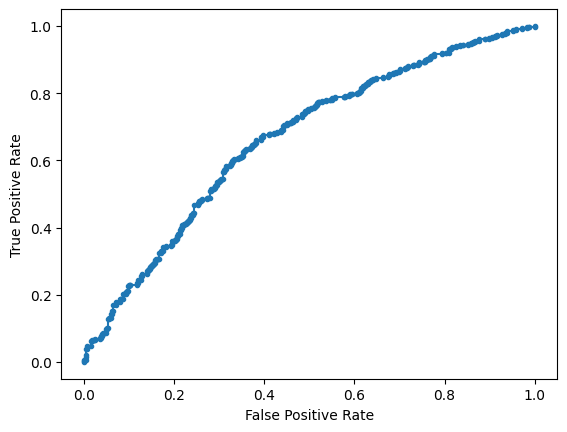

Accuracy: 63.02% Precision: 66.17% Recall: 59.29%
F1: 62.54% MCC: 0.2640
AUPRC: 65.61% AUROC: 66.21%
 accuracy [63.0184331797235]
 precision [66.17283950617285]
 recall [59.29203539823009]
 F1 [62.54375729288214]
 MCC [0.26395655918772765]
 AUPRC [65.60931437674687]
 AUROC [66.2062840367597]

Training # 2 3
2023-04-04 18:55:26.799064
2023-04-04 18:55:27.022183
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-04-04 18:55:27.117559


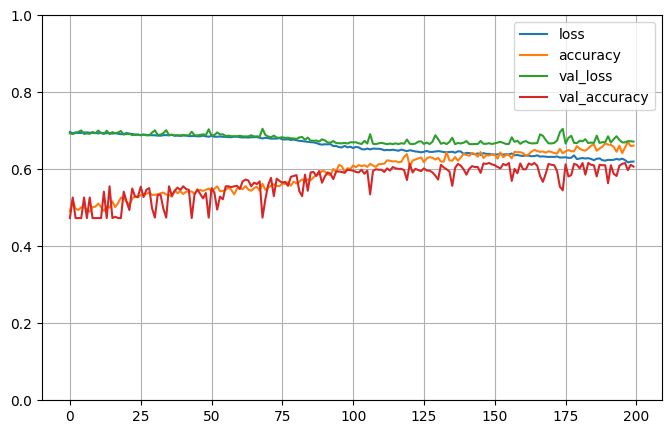


Testing # 2 3
2023-04-04 18:57:51.403064
2023-04-04 18:57:51.403543
2023-04-04 18:57:51.403980
PREDICT
2023-04-04 18:57:51.418133
Test 1:0 453:407 52.67%
Predict 1:0 463:397 53.84%
Test sizes (860, 1025) (860,)
Range of scores: 0.008564503 to 0.95450026
Score threshold 0.5
Confusion matrix
 [[233 174]
 [164 289]]
Normalized matrix
 [[0.27093023 0.20232558]
 [0.19069767 0.33604651]]


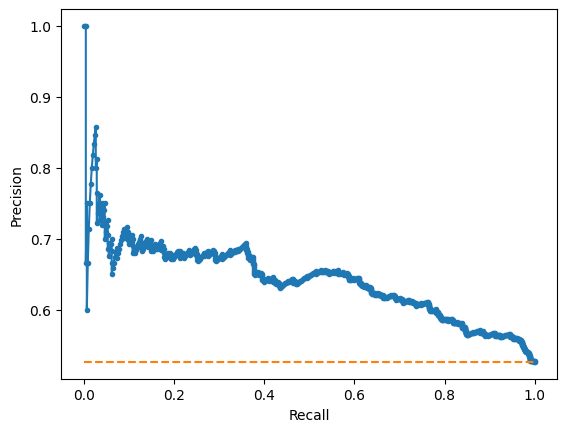

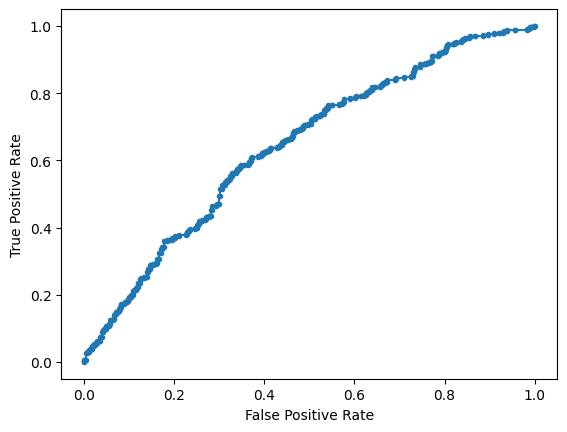

Accuracy: 60.70% Precision: 62.42% Recall: 63.80%
F1: 63.10% MCC: 0.2108
AUPRC: 64.24% AUROC: 64.39%
 accuracy [60.69767441860465]
 precision [62.419006479481645]
 recall [63.796909492273734]
 F1 [63.1004366812227]
 MCC [0.2107710039122883]
 AUPRC [64.24446881601966]
 AUROC [64.38648160502464]

Training # 2 4
2023-04-04 18:57:52.473859
2023-04-04 18:57:52.708760
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-04-04 18:57:52.837451


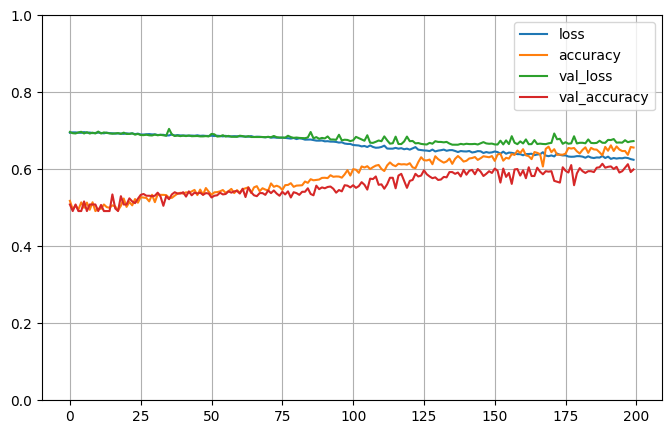


Testing # 2 4
2023-04-04 19:00:16.146700
2023-04-04 19:00:16.146744
2023-04-04 19:00:16.146902
PREDICT
2023-04-04 19:00:16.164114
Test 1:0 432:447 49.15%
Predict 1:0 308:571 35.04%
Test sizes (879, 1025) (879,)
Range of scores: 0.009838943 to 0.9077703
Score threshold 0.5
Confusion matrix
 [[333 114]
 [238 194]]
Normalized matrix
 [[0.37883959 0.12969283]
 [0.27076223 0.22070535]]


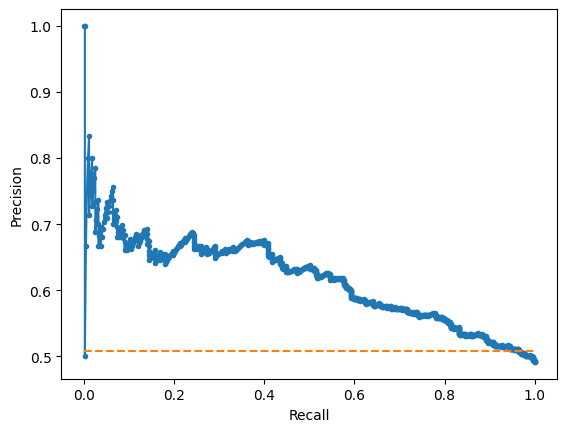

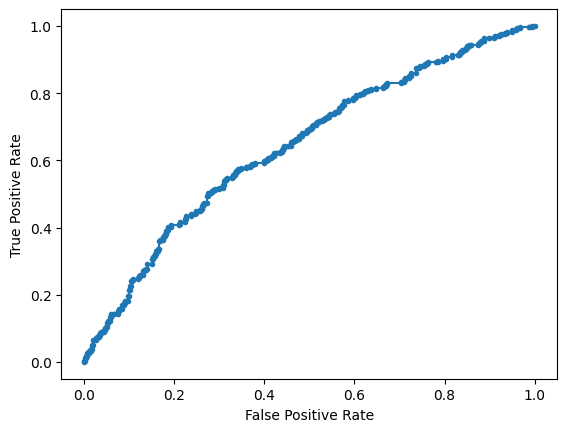

Accuracy: 59.95% Precision: 62.99% Recall: 44.91%
F1: 52.43% MCC: 0.2033
AUPRC: 61.60% AUROC: 64.24%
 accuracy [59.954493742889646]
 precision [62.98701298701299]
 recall [44.907407407407405]
 F1 [52.43243243243243]
 MCC [0.20332680939181727]
 AUPRC [61.59572946768609]
 AUROC [64.24258430690199]

Training # 2 5
2023-04-04 19:00:16.919635
2023-04-04 19:00:17.128053
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-04-04 19:00:17.301042


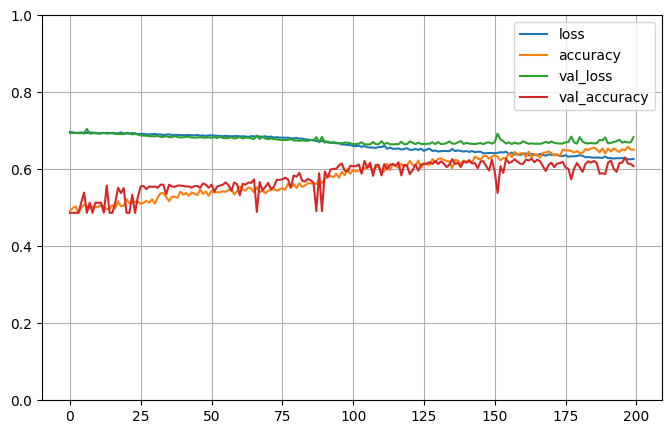


Testing # 2 5
2023-04-04 19:01:50.314052
2023-04-04 19:01:50.314091
2023-04-04 19:01:50.314140
PREDICT
2023-04-04 19:01:50.324770
Test 1:0 449:426 51.31%
Predict 1:0 686:189 78.40%
Test sizes (875, 1025) (875,)
Range of scores: 0.029940486 to 0.98003733
Score threshold 0.5
Confusion matrix
 [[136 290]
 [ 53 396]]
Normalized matrix
 [[0.15542857 0.33142857]
 [0.06057143 0.45257143]]


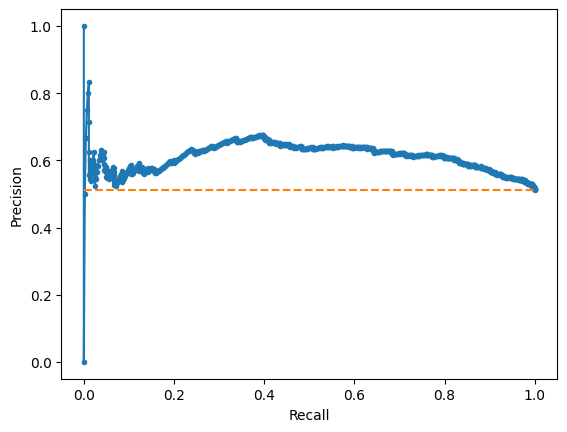

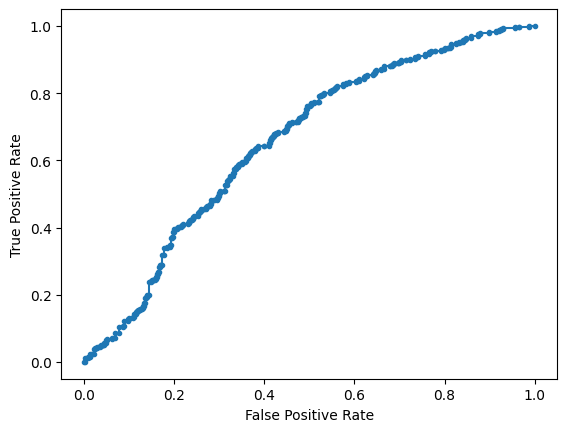

Accuracy: 60.80% Precision: 57.73% Recall: 88.20%
F1: 69.78% MCC: 0.2444
AUPRC: 61.04% AUROC: 65.54%
 accuracy [60.8]
 precision [57.7259475218659]
 recall [88.19599109131403]
 F1 [69.77973568281939]
 MCC [0.24438910759541635]
 AUPRC [61.03887053841813]
 AUROC [65.54210190616602]
2023-04-04 19:01:50.957307


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load training data")
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load test data")
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    r = repeat+1
    for fold in range(FOLDS):
        f = fold+1

        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
           
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)
            
        print()
        print("Testing #",r,f)
        print(datetime.now())
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 60.81% std 1.50
 precision mean 63.22% std 4.11
 recall mean 61.98% std 17.77
 F1 mean 60.85% std 8.17
 MCC mean 0.23% std 0.02
 AUPRC mean 63.54% std 2.06
 AUROC mean 65.49% std 1.21
 accuracy [[61.60919540229885], [61.31221719457014], [58.18610129564193], [60.561797752808985], [59.1324200913242], [62.79594137542277], [63.0184331797235], [60.69767441860465], [59.954493742889646], [60.8]]
 precision [[59.87261146496815], [58.591065292096225], [70.81339712918661], [61.48936170212767], [67.24738675958189], [64.85355648535564], [66.17283950617285], [62.419006479481645], [62.98701298701299], [57.7259475218659]]
 recall [[82.09606986899564], [77.14932126696833], [33.4841628959276], [62.96296296296296], [42.23194748358862], [65.67796610169492], [59.29203539823009], [63.796909492273734], [44.907407407407405], [88.19599109131403]]
 F1 [[69.24493554327809], [66.60156250000001], [45.46850998463901], [62.21743810548978], [51.88172043010753], [65.26315789473684], [62.54375729288214]